<a href="https://colab.research.google.com/github/BillWorstell/DiffDRR/blob/main/CheckFOV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 18.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB

ic| camera_idx: 0
ic| camera_idx: 1
ic| camera_idx: 2
ic| camera_idx: 3
ic| camera_idx: 4
ic| camera_idx: 5
ic| camera_idx: 6
ic| camera_idx: 7
ic| camera_idx: 8
ic| camera_idx: 9
ic| camera_idx: 10
ic| camera_idx: 11
ic| camera_idx: 12
ic| camera_idx: 13
ic| camera_idx: 14
ic| camera_idx: 15
ic| camera_idx: 16
ic| camera_idx: 17
ic| camera_idx: 18
ic| camera_idx: 19
ic| camera_idx: 20
ic| camera_idx: 21
ic| camera_idx: 22
ic| camera_idx: 23
ic| camera_idx: 24
ic| camera_idx: 25
ic| camera_idx: 26
ic| camera_idx: 27
ic| camera_idx: 28
ic| camera_idx: 29
ic| camera_idx: 30
ic| camera_idx: 31
ic| camera_idx: 32
ic| camera_idx: 33
ic| camera_idx: 34
ic| camera_idx: 35
ic| camera_idx: 36
ic| camera_idx: 37
ic| camera_idx: 38
ic| camera_idx: 39
ic| camera_idx: 40
ic| camera_idx: 41
ic| camera_idx: 42
ic| camera_idx: 43
ic| camera_idx: 44
ic| camera_idx: 45
ic| camera_idx: 46
ic| camera_idx: 47
ic| camera_idx: 48
ic| camera_idx: 49
ic| camera_idx: 50
ic| camera_idx: 51
ic| camera_idx: 52
ic|

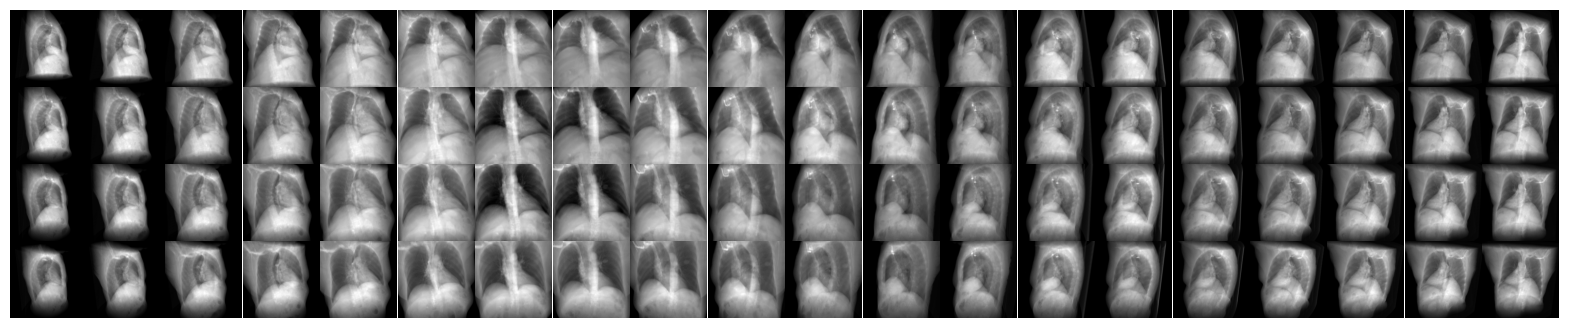

In [1]:
# Install the diffdrr package
!pip install diffdrr
!pip install openpyxl
!pip install icecream

import matplotlib.pyplot as plt
import torch
import numpy as np
from google.colab import drive
from openpyxl import load_workbook
from icecream import ic
from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr

# Read in the volume and get its origin and spacing in world coordinates
subject = load_example_ct()

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mount Google Drive
drive.mount('/content/drive')

# Path to the spreadsheet containing the camera geometry specifications
spreadsheet_path = '/content/drive/MyDrive/SPECTGeometry/MDSL.excel80M10RFR.cut-plate.008.150roi.2.30pin.105ellipse.xlsx'

# Load the workbook and select the appropriate worksheet
wb = load_workbook(filename=spreadsheet_path, data_only=True)
wb.active = 1  # Assuming the relevant sheet is the second one (index 1)
ws = wb.active

# Read lcoll values from the spreadsheet
lcoll = np.array([ws.cell(row=i, column=7).value for i in range(3, 83)])
vsdr = 5. * lcoll  # Example operation on lcoll values

# Read alpha and beta values from the spreadsheet (in radians)
alpha = [ws.cell(row=i, column=22).value - (np.pi/2.) for i in range(3, 83)]
beta = [ws.cell(row=i, column=23).value for i in range(3, 83)]

# Define parameters for DRR generation
SDD = float(2. * vsdr[0])
HEIGHT = 250
DELX = 4.0

# Generate DRRs for all 80 cameras
projections = np.zeros((80,250,250))

for camera_idx in range(80):
    true_params = {
    "sdr": SDD,
    "alpha": alpha[camera_idx],
    "beta": beta[camera_idx],
    "gamma": 0.0,
    "bx": 0.,
    "by": float(vsdr[camera_idx]),
    "bz": 0.,
    }
    device = "cuda" if torch.cuda.is_available() else "cpu"
    drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
    rotations = torch.tensor(
      [
        [
            true_params["alpha"],
            true_params["beta"],
            true_params["gamma"],
        ]
      ]
    ).to(device)
    translations = torch.tensor(
      [
        [
            true_params["bx"],
            true_params["by"],
            true_params["bz"],
        ]
      ]
    ).to(device)
    ground_truth = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZXY",
    )
    ic(camera_idx)
    projections[camera_idx,:,:]=ground_truth.squeeze().cpu().numpy()  # Convert to numpy array if needed

# Setup the plot grid
fig, axes = plt.subplots(nrows=4, ncols=20, figsize=(20, 4), gridspec_kw={'wspace': 0, 'hspace': 0})

# Display the images
for i, ax in enumerate(axes.flat):
    ax.imshow(projections[i], cmap='gray')
    ax.axis('off')  # Turn off axis

plt.show()
